FCPGTools V2 Demo Notebook
===========================

**Key Improvements:**
* Supports file read in from remote-servers via `xarray.open_dataset()` (i.e. [THREDDS](https://www.ncei.noaa.gov/access/thredds-user-guide)).
* Multi-dimensional paramater grid support (i.e. precipitation over time).
* In-memory objects -> no more unnecessary file read/write -> scalable beyond local machines.
* One-line visualizations with `xarray.DataArray.plot()`.
* Refactoring into a modular, non-repetative code base -> improved adaptability long term to dependency shifts and/or new client demands.

## Import notebook dependencies, `fcpgtools`, and directory paths

In [1]:
# import non-fcpgtools dependencies
import xarray as xr
import geopandas as gpd
import numpy as np
import pydaymet
from pathlib import Path
from importlib import reload

In [2]:
# import fcpgtools using conda-develop
!conda-develop C:\\Users\\xrnogueira\\Documents\\FCPGtools\\src
import fcpgtools
reload(fcpgtools)
print(f'fcpgtools directory: {dir(fcpgtools)}')

path exists, skipping C:\Users\xrnogueira\Documents\FCPGtools\src
completed operation for: C:\Users\xrnogueira\Documents\FCPGtools\src
fcpgtools directory: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'terrainengine', 'tools', 'types', 'utilities']


In [3]:
# get all necessary paths for in/out data
examples_dir = str(Path.cwd())
if 'FCPGtools' in examples_dir:
    examples_dir = Path(examples_dir.split('FCPGtools', 2)[0] + 'FCPGtools\\examples')
    print(f'var:examples_dir = {examples_dir}')
else:
    del examples_dir
    print('ERROR: Cant find /FCPGtools/examples!')

var:examples_dir = c:\Users\xrnogueira\Documents\FCPGtools\examples


In [4]:
# get all necessary paths for in/out data
in_data_dir = examples_dir / Path('in_data')
print(f'Variable in_data_dir accesses {in_data_dir}')
out_data_dir = examples_dir / Path('out_data')
print(f'Variable in_data_dir accesses {out_data_dir}')

Variable in_data_dir accesses c:\Users\xrnogueira\Documents\FCPGtools\examples\in_data
Variable in_data_dir accesses c:\Users\xrnogueira\Documents\FCPGtools\examples\out_data


# Import Data
**Local files:**
* `us_fdr`: upstream basin Flow Direction Raster (ESRI format).
* `ds_fdr`: downstream basin Flow Direction Raster (ESRI format).
* `landcover`: 
* `basins_shp`:

**Remote files:**
* `precip`: a 2021 monthly averaged DAYMET precipitation raster via `pydaymet`.

## Pull in local test data

### Get local raster files as `xr.DataArray`s 
**Note:** While seemingly redundant, using `pathlib.Path` objects improves application security, especially if deployed on a remote server. This is because string paths are passed into TauDEM command line calls, which opens a vunerability to custom strings that could control a server remotely. Assuring that all inputs are valid paths (therefore not arbitrary malicious strings), protects against this.

In [47]:
# get tif data paths
us_fdr_tif = in_data_dir / Path('validation_upstream_fdr.tif')
ds_fdr_tif = in_data_dir / Path('validation_downstream_fdr.tif')
landcover_tif = in_data_dir / Path('NALCMS_2015.tif')

# get upstream basin shapefile path
us_basin_shp_path = in_data_dir / Path('upstream_wbd.shp')

In [33]:
us_fdr = fcpgtools.utilities.intake_raster(us_fdr_tif)
ds_fdr = fcpgtools.utilities.intake_raster(ds_fdr_tif)
landcover = fcpgtools.utilities.intake_raster(landcover_tif)

### Use `tools.convert_fdr_formats()` to make an TauDEM and ESRI format D8 FDR

In [34]:
# display the dicts sotring D8 formats
print('D8 Formats supported by FCPGtools:')
display(fcpgtools.types.D8ConversionDicts)

D8 Formats supported by FCPGtools:


{'taudem': {'southeast': 8,
  'south': 7,
  'southwest': 6,
  'west': 5,
  'northwest': 4,
  'north': 3,
  'northeast': 2,
  'east': 1,
  'nodata': 0},
 'esri': {'southeast': 2,
  'south': 4,
  'southwest': 8,
  'west': 16,
  'northwest': 32,
  'north': 64,
  'northeast': 128,
  'east': 1,
  'nodata': 255}}

In [35]:
%%time
# make a taudem FDR
us_fdr_taudem = fcpgtools.tools.convert_fdr_formats(
        us_fdr,
        out_format='taudem',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from esri format to {out_format}
CPU times: total: 938 ms
Wall time: 931 ms


TauDEM format ustream basin FDR


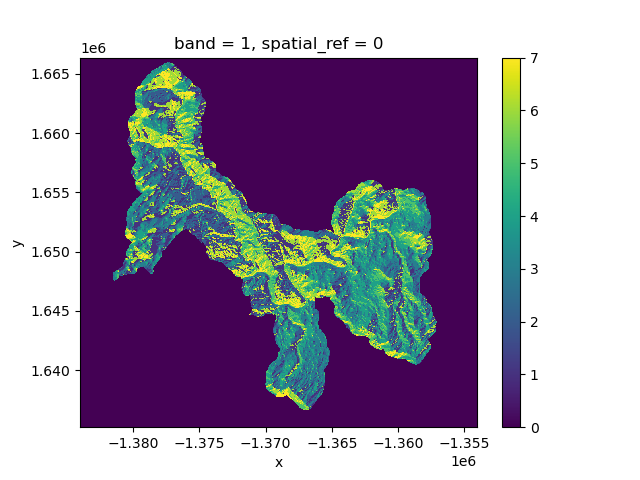

In [36]:
%matplotlib widget
print('TauDEM format ustream basin FDR')
us_fdr_taudem.plot()

In [37]:
%%time
# test back-conversion by re-making the esri format FDR
us_fdr_esri = fcpgtools.tools.convert_fdr_formats(
        us_fdr_taudem,
        out_format='esri',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from taudem format to {out_format}
CPU times: total: 797 ms
Wall time: 804 ms


ESRI format ustream basin FDR


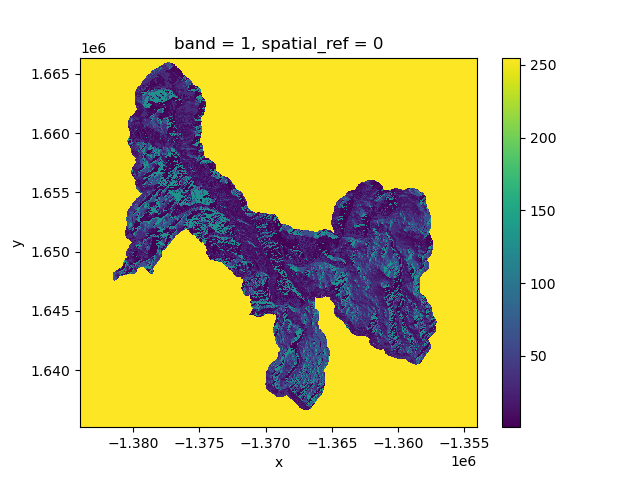

In [38]:
%matplotlib widget
print('ESRI format ustream basin FDR')
us_fdr_esri.plot()

### Get the upstrean basin shapefile as a `geopandas.GeoDataFrame`

In [39]:
us_basin_shp = gpd.read_file(us_basin_shp_path)
us_basin_shp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,GNIS_ID,Name,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,0,Honey Draw-Colorado River,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-111.45208 36.90750, -111.45209 36.9..."
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,0,Johnson Point-Paria River,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-111.69386 37.00586, -111.69386 37.0..."


## Import a 12 month DAYMET precipitation raster from THREDDS using our AOI
**Note:** Here we use [`pydaymet`](https://hyriver.readthedocs.io/en/latest/autoapi/pydaymet/pydaymet/index.html) to read Daymet data directly into a `xr.DataSet`. We then query only for precipitation (`variable='prcp')` to get a `xr.DataArray`.

In [40]:
bounding_box = list(us_basin_shp.geometry.total_bounds)
print(f'Boudning box: {bounding_box}')

Boudning box: [-111.71574357557677, 36.771840865839465, -111.43463711872147, 37.00637998943375]


In [41]:
%%time
daymet_precip = pydaymet.get_bygeom(bounding_box,
    crs=us_basin_shp.crs.to_wkt(),
    dates=("2021-01-01", "2021-12-30"),
    variables='prcp',
    time_scale="monthly",
    )['prcp']
daymet_precip.head()

CPU times: total: 3.05 s
Wall time: 3.14 s


<xarray.DataArray 'prcp' (time: 5, y: 5, x: 5)>
dask.array<getitem, shape=(5, 5, 5), dtype=float32, chunksize=(5, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-16T12:00:00 ... 20...
  * y                        (y) float32 -513.0 -514.0 -515.0 -516.0 -517.0
  * x                        (x) float32 -1e+03 -999.2 -998.2 -997.2 -996.2
    lambert_conformal_conic  int32 0
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    units:         mm
    long_name:     monthly total precipitation
    _ChunkSizes:   [ 10 300 300]

Visualizing January precipitation:


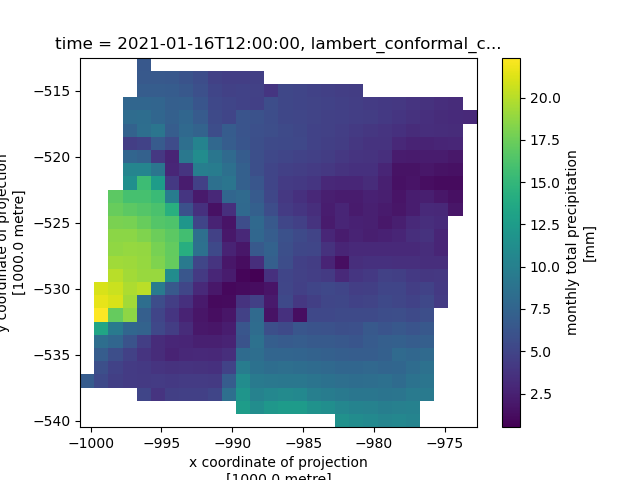

In [42]:
%matplotlib widget
print('Visualizing January precipitation:')
daymet_precip.isel(time=0).plot()

### Use `tools.align_raster()` to align both `daymet_precip` and `landcover` to our FDRs
Note: The `tools.align_raster()` function matches the projection/Coordinate-Reference-System (CRS), cell size, and extent of any raster to any other raster. This enables array-like calculations. If the user wants to change only certain aspects of a raster (i.e. match cell size only), one can use the `utilities.clip()`, `utilities.resample()`, and `utilities.reproject()` functions. 

Upstream basin: January daymet precipitaion post alignment


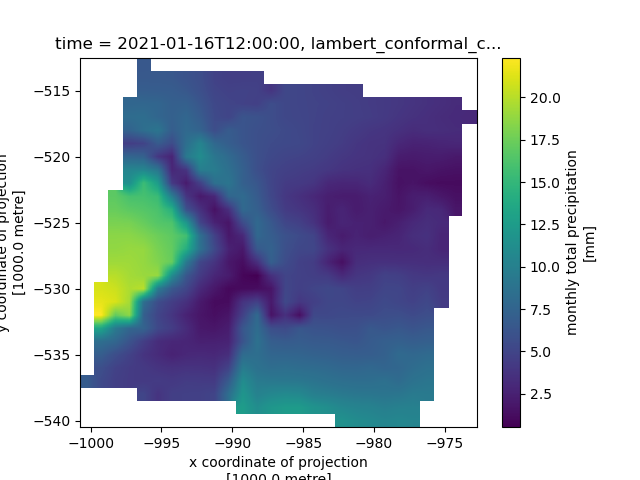

In [45]:
%matplotlib widget
us_daymet_precip = fcpgtools.tools.align_raster(
    in_raster=daymet_precip,
    match_raster=us_fdr,
)
print('Upstream basin: January daymet precipitaion post alignment')
us_daymet_precip.isel(time=0).plot()

In [44]:
%matplotlib widget
us_landcover = fcpgtools.tools.align_raster(
    in_raster=landcover,
    match_raster=us_fdr,
)
print('Landcover data post alignment')
us_landcover.plot()

ValueError: dst_nodata must be in valid range for destination dtype

# Make a Flow Accumulation Cell (FAC) raster from a Flow Direction Raster (FDR)
**Note:** The v2 versino of FCPGTools supports multiple "geoprocessing engines" which can be used interchangably. **In this demo we use [`pysheds`](http://mattbartos.com/pysheds/), although legacy TauDEM support is also possible.**

## Make a stream mask raster based on a cell accumulation threshold

# Prepare parameter grids

## Clip, reproject, and resample (one-by-one)

## Or align parameter grid to the FDR in one line

# Make a parameter grid FAC raster

# Create a multi-dimensional Flow Conditioned Parameter Grid (FCPG)

# Compare with V1 implementation